# <U>WOMENS CLOTHING (E-COMMERCE): VOICE OF CUSTOMERS

### Topic Modeling (Based on Reviews)

<B>DESCRIPTION:

Help a leading Women's Clothing brand on E-Commerce to understand the voice of the customer by analyzing the reviews of their product and the topics that customers are talking about. Performing Topic Modeling on specific part of speech to finally interpret the emerging topics.

<b>Problem Statement:

A popular Women's Clothing brand on E-Commerce wants to understand the VOC (voice of the customer) on the product. This will be useful to not just evaluate the current product, but to also get some direction for developing the product pipeline. The client is particularly interested in the different aspects that customers care about. Product reviews by customers on a leading e-commerce site should provide a good view.

    
<b> Outline:
- Importing Libraries
- Loading Dataset
- Data Exploration
- Data Pre-processing
- Text Pre-processing
- Word-Cloud Vizualization
- Bag of Words on the Dataset
- Running LDA using Bag of Words
- Hyperparameter Tuning
- Topics
- Visualize Topics
- Insights

### Importing Libraries:

In [1]:
import re
import pandas as pd
import numpy as np
import glob
import string
import nltk
import gensim
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# nltk.download("stopwords")
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.stem import SnowballStemmer
pd.options.display.max_columns = None
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import collections

from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

#consistent sized plots
from pylab import rcParams
rcParams['figure.figsize']=12,5
rcParams['axes.labelsize']=12
rcParams['ytick.labelsize']=12
rcParams['xtick.labelsize']=12

import warnings
warnings.filterwarnings('ignore')

### Loading Dataset:

In [2]:
# Load the data

df = pd.read_csv("/Users/gauravsharma/Documents/DLNLP/Data/Womens Clothing E-Commerce Reviews.csv", index_col=0)

<b> About Dataset

In [3]:
# The first 5 rows of the data
df.head(5)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### Data Exploration

In [4]:
# The dimension f the data
df.shape

(23486, 10)

In [5]:
# The name of columns in the data
df.columns

Index(['Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')

In [6]:
df.rename(columns = {'Review Text':'Review'}, inplace = True)

In [7]:
# Data types of each column
df.dtypes

Clothing ID                 int64
Age                         int64
Title                      object
Review                     object
Rating                      int64
Recommended IND             int64
Positive Feedback Count     int64
Division Name              object
Department Name            object
Class Name                 object
dtype: object

### Data Pre-processing


In [8]:
# Checking for duplicated entries
duplicates = df.duplicated().sum() 
if  duplicates == 0:
    print("There are no duplicted rows in this data")
else:
    print(f"There are: {duplicates} duplicated rows")

There are: 21 duplicated rows


In [9]:
# Drop the duplicated rows
df=df.drop_duplicates()

In [10]:
# Number of null in each column
df.isnull().sum()

Clothing ID                   0
Age                           0
Title                      3789
Review                      825
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [11]:
# Drop rows with null values in "Review Text" column
df = df.dropna(subset=["Review"])

In [12]:
# selecting only required columns for ML models
df_text = df[["Review", "Recommended IND"]]

In [13]:
# number of reviews that recommeneded the product
df_text[(df_text['Recommended IND']==1)].shape[0]

18539

### Text Preprocessing

In [14]:
# Preprocess the text with function processtext()

stop_words = stopwords.words('english')
# Remove Negative verbs and "not" from stop_words
stop_words_new = stop_words[:-36]
stop_words_new.remove("not")

punctuations = list(string.punctuation)
lemma = WordNetLemmatizer() # for Lemmatisation
REPLACE_APS = re.compile(r"[\']") 

def processtext(text):
    text=re.sub("[^a-zA-Z]"," ",text) # Filter to allow only alphabets in text
    text=text.lower() # Convert the text to lowercase to maintain consistency
    text = REPLACE_APS .sub("", text)
    tokens=word_tokenize(text) # Tokenize the text
    # Remove stopwords and punctuations
    tokens=[token for token in tokens if token not in stop_words_new and token not in punctuations] 
    tokens=[lemma.lemmatize(token) for token in tokens] # Lemmatisation of tokens
    text=" ".join(tokens)
    return text

In [15]:
# Preprocess the "Review" column with function processtext()
df_text["processed_Review"] = df_text["Review"].apply(lambda x: processtext(x))

In [16]:
#function to proprocess the entire dataset 

stemmer = SnowballStemmer('english')

def lemmatize_stemming(text):
    #This function will lemmatize on Noun POS and stem the text
    return stemmer.stem(WordNetLemmatizer().lemmatize(text,pos='n'))
    #return (WordNetLemmatizer().lemmatize(text,pos='n'))

#tokenize and lemmatize
def preprocess(text):
    #Function to break into word tokens, remove stopwords, remove short words and finally to lemmatize and stem the individual tokens
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [17]:
#check randomly any of the reviews
random = np.random.randint(1,len(df))
print(df['Review'][random])

Walked into the store and the first thing that caught my eye was this dress. great pattern and fabric, a quality, versatile piece. i am a size 4 and purchased an xs petite, seems to run just a tad big.


In [18]:
#check for a sample review
result = preprocess('Walked into the store and the first thing that caught my eye was this dress. great pattern and fabric, a quality, versatile piece. i am a size 4 and purchased an xs petite, seems to run just a tad big.')
print(result)

['walk', 'store', 'thing', 'caught', 'dress', 'great', 'pattern', 'fabric', 'qualiti', 'versatil', 'piec', 'size', 'purchas', 'petit']


In [19]:
processed_docs = []

#uncomment below line to find the topics for a particular sentiment
#reviews = reviews[reviews['sentiment']==1]

for doc in df['Review']:
    processed_docs.append(preprocess(doc))

In [20]:
#Preview the processed documents

print(processed_docs[:10])

[['absolut', 'wonder', 'silki', 'sexi', 'comfort'], ['love', 'dress', 'sooo', 'pretti', 'happen', 'store', 'glad', 'order', 'onlin', 'petit', 'bought', 'petit', 'love', 'length', 'hit', 'littl', 'knee', 'definit', 'true', 'midi', 'truli', 'petit'], ['high', 'hope', 'dress', 'want', 'work', 'initi', 'order', 'petit', 'small', 'usual', 'size', 'outrag', 'small', 'small', 'fact', 'reorder', 'petit', 'medium', 'overal', 'half', 'comfort', 'nice', 'half', 'tight', 'layer', 'somewhat', 'cheap', 'layer', 'major', 'design', 'flaw', 'layer', 'sewn', 'direct', 'zipper'], ['love', 'love', 'love', 'jumpsuit', 'flirti', 'fabul', 'time', 'wear', 'great', 'compliment'], ['shirt', 'flatter', 'adjust', 'perfect', 'length', 'wear', 'leg', 'sleeveless', 'pair', 'cardigan', 'love', 'shirt'], ['love', 'traci', 'rees', 'dress', 'petit', 'foot', 'tall', 'usual', 'wear', 'brand', 'dress', 'pretti', 'packag', 'dress', 'skirt', 'long', 'overwhelm', 'small', 'frame', 'stranger', 'alter', 'shorten', 'narrow', 'sk

### Wordcloud Visualization

In [21]:
pos_df = df_text[df_text['Recommended IND']== 1]
neg_df = df_text[df_text['Recommended IND']== 0]
pos_df.head(3)

,Review,Recommended IND,processed_Review
0,Absolutely wonderful - silky and sexy and comf...,1,absolutely wonderful silky sexy comfortable
1,Love this dress! it's sooo pretty. i happene...,1,love dress sooo pretty happened find store gla...
3,"I love, love, love this jumpsuit. it's fun, fl...",1,love love love jumpsuit fun flirty fabulous ev...


In [22]:
pos_words =[]
neg_words = []

for review in pos_df.processed_Review:
    pos_words.append(review) 
pos_words = ' '.join(pos_words)
pos_words[:40]

for review in neg_df.processed_Review:
    neg_words.append(review)
neg_words = ' '.join(neg_words)
neg_words[:400]

'high hope dress really wanted work initially ordered petite small usual size found outrageously small small fact could not zip reordered petite medium ok overall top half comfortable fit nicely bottom half tight layer several somewhat cheap net layer imo major design flaw net layer sewn directly zipper c love tracy reese dress one not petite foot tall usually wear p brand dress pretty package lot '

<b> Wordcloud: Positive Reviews

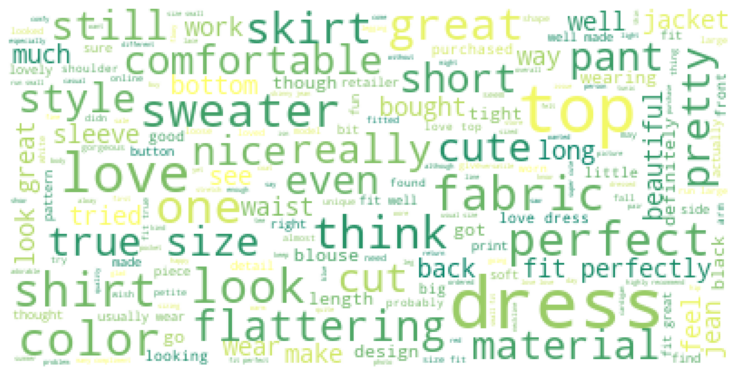

In [23]:
wordcloud = WordCloud().generate(pos_words)

wordcloud = WordCloud(background_color="white",max_words=len(pos_words),\
                      max_font_size=40, relative_scaling=.5, colormap='summer').generate(pos_words)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

<b>Wordcloud: Negative Reviews

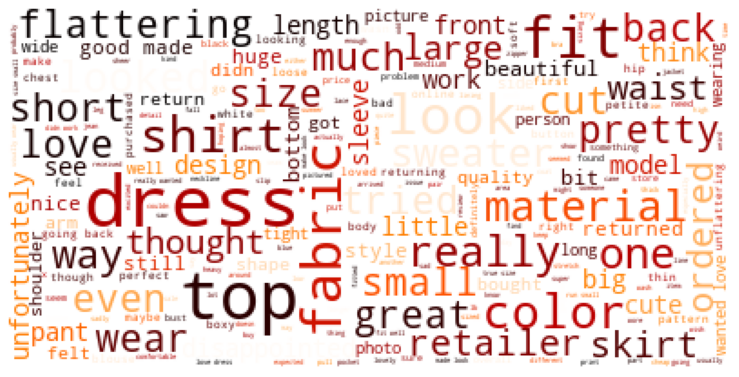

In [24]:
wordcloud = WordCloud().generate(neg_words)

wordcloud = WordCloud(background_color="white",max_words=len(neg_words),\
                      max_font_size=40, relative_scaling=.5, colormap='gist_heat').generate(neg_words)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Bag of Words on the Dataset¶

In [25]:
#Create a dictionary of the words which appear in the entire corpus

import gensim.corpora as corpora
# Create Dictionary
dictionary = corpora.Dictionary(processed_docs)
# Create Corpus
texts = processed_docs
# Term Document Frequency
corpus = [dictionary.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


In [26]:
dictionary.keys()[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [27]:
#print a few words in the dictionary
count = 0
for k,v in dictionary.iteritems():
    print(k,v)
    count = count + 1
    if count > 10:
        break

0 absolut
1 comfort
2 sexi
3 silki
4 wonder
5 bought
6 definit
7 dress
8 glad
9 happen
10 hit


<b>Gensim filter extremes

- Remove or filter the words that appear less than no-below
- Remove or filter the words that apepar more than no-above (fraction)
- After the above two steps keep only the n most frequent tokens or keep all

In [28]:
dictionary.filter_extremes(no_below=5,no_above=0.1,keep_n=None)

<b>Gensim doc2bow

Create a bag of words for each document ie for each document we create a dictionary reporting how many words and how many times those words appear

In [29]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[10:20]

[[(12, 1),
  (17, 1),
  (33, 1),
  (35, 1),
  (98, 2),
  (107, 1),
  (110, 1),
  (111, 1),
  (112, 1),
  (113, 1),
  (114, 1),
  (115, 2),
  (116, 1),
  (117, 1),
  (118, 1)],
 [(12, 1)],
 [(8, 1),
  (79, 1),
  (97, 1),
  (119, 1),
  (120, 1),
  (121, 1),
  (122, 1),
  (123, 2),
  (124, 1),
  (125, 1),
  (126, 1),
  (127, 1),
  (128, 1),
  (129, 1),
  (130, 1),
  (131, 1),
  (132, 1),
  (133, 1),
  (134, 1),
  (135, 1),
  (136, 1)],
 [(8, 1),
  (9, 1),
  (12, 1),
  (22, 1),
  (62, 1),
  (98, 1),
  (123, 1),
  (137, 1),
  (138, 1),
  (139, 1),
  (140, 1),
  (141, 1),
  (142, 1),
  (143, 1),
  (144, 1),
  (145, 1),
  (146, 1),
  (147, 1)],
 [(4, 1),
  (8, 1),
  (26, 1),
  (62, 1),
  (94, 2),
  (98, 1),
  (130, 1),
  (148, 1),
  (149, 1),
  (150, 1),
  (151, 2),
  (152, 1),
  (153, 1),
  (154, 1),
  (155, 1),
  (156, 1),
  (157, 1),
  (158, 1),
  (159, 1),
  (160, 1),
  (161, 1),
  (162, 1)],
 [(12, 1),
  (24, 1),
  (33, 1),
  (34, 1),
  (58, 1),
  (78, 1),
  (162, 2),
  (163, 1),
  (164,

In [30]:
document_num = random
bow_doc_x = bow_corpus[random]

for i in range(len(bow_doc_x)):
    print(f'Word {bow_doc_x[i][0]} {dictionary[bow_doc_x[i][0]]} appears {bow_doc_x[i][1]} times')

Word 137 black appears 1 times
Word 215 simpl appears 1 times
Word 710 closet appears 1 times
Word 1092 stapl appears 1 times


### Running LDA using Bag of Words

In [31]:
#apply the gensim LDA model and generate 12 topics from the corpus
seed = 0
lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,num_topics=15,id2word=dictionary,passes=10,workers=2,
                                      random_state=seed,minimum_probability=0.05,alpha='symmetric')

In [32]:
#For each topic, explore each word and its relative weight in the topic

for idx,topic in lda_model.print_topics(-1,num_words=15):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.080*"store" + 0.063*"onlin" + 0.055*"tri" + 0.023*"retail" + 0.021*"person" + 0.014*"thought" + 0.013*"local" + 0.012*"went" + 0.012*"arriv" + 0.011*"fell" + 0.011*"button" + 0.011*"pictur" + 0.011*"wasn" + 0.010*"immedi" + 0.010*"couldn"


Topic: 1 
Words: 0.118*"sweater" + 0.028*"warm" + 0.027*"sleev" + 0.024*"fall" + 0.023*"coat" + 0.019*"winter" + 0.018*"long" + 0.015*"weather" + 0.014*"cardigan" + 0.013*"cozi" + 0.013*"layer" + 0.013*"knit" + 0.012*"jacket" + 0.011*"itchi" + 0.009*"wool"


Topic: 2 
Words: 0.060*"review" + 0.037*"compliment" + 0.024*"receiv" + 0.022*"medium" + 0.021*"purchas" + 0.020*"wore" + 0.017*"glad" + 0.016*"sale" + 0.015*"retail" + 0.013*"read" + 0.013*"time" + 0.012*"run" + 0.012*"normal" + 0.011*"agre" + 0.011*"said"


Topic: 3 
Words: 0.022*"shoulder" + 0.020*"run" + 0.018*"definit" + 0.016*"think" + 0.014*"arm" + 0.014*"pretti" + 0.014*"person" + 0.014*"recommend" + 0.013*"short" + 0.010*"normal" + 0.010*"high" + 0.010*"romper" + 0.01

In [33]:
#import Coherence model from gensim
from gensim.models import CoherenceModel
#compute coherence score
lda_model_coherence = CoherenceModel(model=lda_model,texts=processed_docs,dictionary=dictionary,
                                    coherence='c_v')
coherence_lda = lda_model_coherence.get_coherence()
print('\nCoherence Score:',coherence_lda)


Coherence Score: 0.45881188864084593


### Hyperparameter Tuning

- Number of topics K
- Dirichlet hyperparamater alpha: Document Topic Density
- Dirichlet hyperparameter beta: Word-Topic Density

In [34]:
#define a helper function
def compute_coherence_score(corpus,dictionary,k,a):
    #instantiate the model instance based on k,a and b
    lda_model = gensim.models.LdaMulticore(corpus=corpus,id2word=dictionary,num_topics=k,alpha=a,
                                           passes=10,
                                           random_state=seed)
    lda_model_coherence = CoherenceModel(model=lda_model,texts=processed_docs,dictionary=dictionary,coherence='c_v')
    return lda_model_coherence.get_coherence()

In [35]:
#search for the best alpha and the number of topics --> one with the highest coherence score will be the best hyperparameter
alpha =['symmetric','asymmetric']

for x in alpha:
    print('Coherence Model with alpha = {}'.format(x))
    print('-------------------------------------------')
    print('\n')
    for i in range(12,18):
        score = compute_coherence_score(corpus=bow_corpus,dictionary=dictionary,k=i,a=x)        
        print(f'Coherence score with {i} topics is {score}')
        print('\n')

Coherence Model with alpha = symmetric
-------------------------------------------


Coherence score with 12 topics is 0.3830700230795821


Coherence score with 13 topics is 0.39332959951380986


Coherence score with 14 topics is 0.3980819865274772


Coherence score with 15 topics is 0.39222302162971506


Coherence score with 16 topics is 0.3927777781375915


Coherence score with 17 topics is 0.40042749644671444


Coherence Model with alpha = asymmetric
-------------------------------------------


Coherence score with 12 topics is 0.3893881347715001


Coherence score with 13 topics is 0.39388954905139373


Coherence score with 14 topics is 0.3957887613854313


Coherence score with 15 topics is 0.3963263859228959


Coherence score with 16 topics is 0.3946778147028819


Coherence score with 17 topics is 0.39044786264606146




<b>Though the model with alpha='asymmetric' and with 14 topics returned the highest coherence score. For the business use and simplicity, max topics of 7
and alpha='asymmetric' as the final model. This also returned a comparable coherence score of 0.4601

In [36]:
lda_model_final = gensim.models.LdaMulticore(corpus=bow_corpus,num_topics=14,id2word=dictionary,passes=10,workers=2,alpha='asymmetric')

In [37]:
from pprint import pprint
# Print the Keyword in the 14 topics
pprint(lda_model_final.print_topics())
doc_lda = lda_model_final[bow_corpus]

[(0,
  '0.028*"white" + 0.023*"pretti" + 0.019*"tank" + 0.017*"sheer" + '
  '0.017*"blous" + 0.016*"underneath" + 0.015*"feel" + 0.015*"run" + '
  '0.012*"need" + 0.012*"cami"'),
 (1,
  '0.049*"waist" + 0.033*"short" + 0.023*"high" + 0.020*"jean" + '
  '0.019*"stretch" + 0.019*"leg" + 0.018*"pant" + 0.013*"long" + 0.012*"right" '
  '+ 0.012*"feel"'),
 (2,
  '0.019*"print" + 0.014*"line" + 0.014*"pattern" + 0.013*"feel" + '
  '0.012*"waist" + 0.012*"flow" + 0.011*"style" + 0.011*"gorgeous" + '
  '0.011*"belt" + 0.011*"design"'),
 (3,
  '0.063*"jean" + 0.034*"pant" + 0.033*"pair" + 0.026*"black" + 0.023*"leg" + '
  '0.023*"casual" + 0.021*"worn" + 0.020*"boot" + 0.020*"skinni" + '
  '0.012*"super"'),
 (4,
  '0.062*"store" + 0.047*"onlin" + 0.040*"tri" + 0.026*"retail" + 0.018*"sale" '
  '+ 0.017*"blue" + 0.017*"purchas" + 0.016*"person" + 0.014*"went" + '
  '0.011*"local"'),
 (5,
  '0.097*"petit" + 0.044*"regular" + 0.024*"long" + 0.021*"tri" + 0.020*"pant" '
  '+ 0.013*"need" + 0.013*"k

#### Topics

1. Fitting of the clothing product is appreciated.
2. Worth purchasing clothing products during sales both online and retail store.
3. Clothing products returns as they tends to sheer after wash.
4. Expectations are high from retails stores.
5. Summer clothing collections appreciated by customers.
6. Recommendation for comfortable seasonal clothing. 
7. Casual and light clothing e.g. tank-tops in demand during summer season.
8. Compliments on casual outfit majorly with versatile black jackets.
9. Customers reported feeling itchi over arms and neck while wearing sweaters.
10. Strap-patterns with tight body fit over chest is recommended.
11. Products return overe size issues.
12. High-waist skinni and stretchable jeans/ pants with short lenght in demand.
13. Regular torso fit clothing is preferable.
14. Products image in different color on online purchase is recommended.

### Visualize Topics

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from imp import reload
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lda_model, corpus, dictionary)
lda_viz

### Insights

- <u><i>Sales Advertisement:
    
    - Brand should promote sales to increase footfall both online and store retails. 
    - Also, brand should focus on meeting customer expectaion for retail stores for better customer experience and satisfaction.
    
- <u><i>Product Quality Control:
    
    - Brand need to increase standards and protocols of product quality test process in terms of size measurements, product shrinkage after wash.
    
- <u><i>Dermatology Test (skin-disorders):
    
    - Brand need to improove/ adopt dermatological test for chemicals used in manufacturing process i.e color-dye, washing chemicals etc
    
- <u><i>Seasonal Branding:
    
    - Brand should promote seasonal clothing to focus and meet seasonal clothing demand.
    
- <u><i>Product Catalogue:
    
    - Brand need to display products in all the colors available for their product catalogue